In [1]:
# BAM
from bam_gym.envs import GraspNetEnv
from bam_utils.o3d_helper import o3d_view_rgbd_mask
from ros_py_types.converter import segment2d_array_to_mask_img
from bam_utils.matplotlib_helper import plot_rgbd_mask
from ros_py_types.sensor_msgs import CompressedImage, Image, CameraInfo

# PYTHON
import numpy as np
import open3d as o3d
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


%load_ext autoreload
%autoreload 2



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
env = GraspNetEnv("/home/bam/graspnetAPI/graspnet", render_mode="human")

[UNCONFIGURED] GraspNetEnv


Checking Scene Datas: 100%|██████████| 100/100 [00:00<00:00, 182.55it/s]


[SUCCESS] Data check complete
[READY] GraspNetEnv


In [3]:
import json

print(env.action_space)
print(env.observation_space)

# these don't really mean much, just I guess if you want to sample?

action = env.action_space.sample()
print(action)

Box([-10.        -10.        -10.         -3.1415927  -3.1415927  -3.1415927
   0.       ], [10.        10.        10.         3.1415927  3.1415927  3.1415927
  0.1      ], (7,), float32)
Dict('color_img': Box(0, 255, (480, 600, 3), uint8), 'depth_img': Box(0, 65535, (480, 600), uint16), 'camera_info': Dict('d': Box(-1000000.0, 1000000.0, (8,), float64), 'height': Box(0, 10000, (), int32), 'k': Box(-1000000.0, 1000000.0, (9,), float64), 'width': Box(0, 10000, (), int32)), 'segments': Sequence(Dict('header': Dict(), 'segments': Sequence(Dict('bbox': Dict(), 'header': Dict(), 'id': Text(1, 64, charset=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz), 'img_height': Box(0, 65535, (), int64), 'img_width': Box(0, 65535, (), int64), 'mask': Dict(), 'polygon': Sequence(Dict(), stack=False), 'results': Sequence(Dict(), stack=False)), stack=False)), stack=False))
[-7.8381295  -0.8267783   1.5702955   2.4180892  -2.1769025   0.39210975
  0.05286887]


In [4]:
print("Num Scenes: ", len(env.graspnet.sceneIds))

Num Scenes:  100


In [5]:
obs, info = env.reset()
print(obs.keys())
print(info.keys())
print(info["scene_id"], info["ann_id"])

dict_keys(['camera_info', 'color_img', 'depth_img', 'segments'])
dict_keys(['ns', 'duplicate_obs', 'duplicate_index', 'target_class', 'executed', 'header', 'scene_id', 'ann_id'])
0 0


In [6]:
camera_info: CameraInfo = obs["camera_info"]
color_img: CompressedImage = obs["color_img"]
depth_img: Image = obs["depth_img"]
mask_img = segment2d_array_to_mask_img(obs["segments"])
print(mask_img.shape)

(720, 1280)


In [7]:
# o3d_view_rgbd_mask(camera_info, color_img.data, depth_img.data, mask_img, None, None)

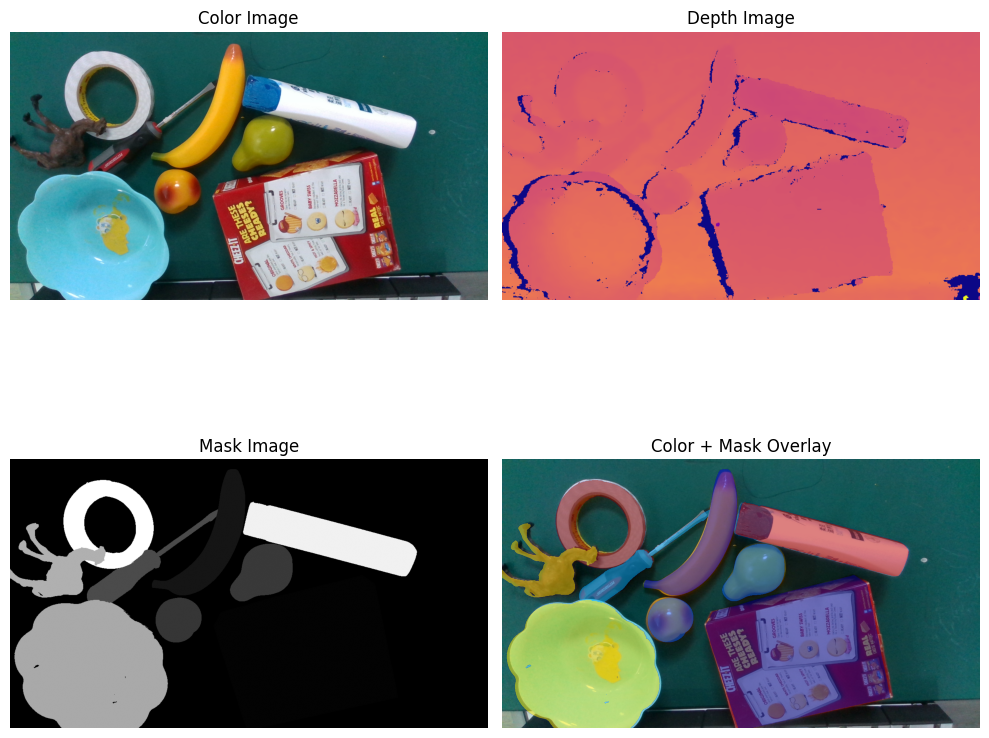

In [8]:
plot_rgbd_mask(color_img.data, depth_img.data, mask_img)

In [9]:
action = env.action_space.sample()
print(action)
# action = np.array([0, 0, 0.3, np.pi/2, -np.pi/2, 0, 0.05]) # manually transform into frame
action = np.array([0, 0, 0.3, 0, -1, 0, 0.05]) # This should have the TCP perfectly aligned at the camera origin

print(action)

[ 8.691719    4.2861204  -9.439577    0.21641189  2.3245552   2.7670856
  0.08764276]
[ 0.    0.    0.3   0.   -1.    0.    0.05]


In [10]:
# Instead of guessing the inverse, just calculate it directly!
from transforms3d.euler import euler2mat, mat2euler
T_graspnet_tcp = np.eye(4)
T_graspnet_tcp[:3, :3] = euler2mat(-np.pi/2, 0, -np.pi/2)
T_graspnet_tcp[:3, 3] = np.array([1, 0, 0]) #x axis is in z direction, depth already has -0.02 applied
T_tool_tcp = np.linalg.inv(T_graspnet_tcp)
print(np.round(T_tool_tcp,3))
print(mat2euler(T_tool_tcp[:3, :3], axes='sxyz'))

[[ 0. -1. -0. -0.]
 [ 0.  0. -1. -0.]
 [ 1.  0.  0. -1.]
 [ 0.  0.  0.  1.]]
(1.5707963267948966, -1.5707963267948966, 0.0)


In [8]:
obs, reward, terminated, truncated, info = env.step(action)

Loading scene models... this takes a sec
scores:  [-1.]
reward:  [0.]
Scene scene_0000, realsense


Ok making progress, the next thing I need to do is make sure that the grasp frame of ref in camera frame is consitent!!!



In [21]:
graspnet_grasps = env.load_graspnet_grasps(info["scene_id"], info["ann_id"])

Loading grasping labels...: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


Loading collision labels...: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]


Loaded grasps: 16844
Returning grasps: 20


In [10]:
# Careful, if you just naively pass in these grasps without the correct height and depth they will all be in collision!
for g in graspnet_grasps:
    print(g.height, g.depth)

0.019999999552965164 0.009999999776482582
0.019999999552965164 0.009999999776482582
0.019999999552965164 0.019999999552965164
0.019999999552965164 0.029999999329447746
0.019999999552965164 0.019999999552965164
0.019999999552965164 0.019999999552965164
0.019999999552965164 0.009999999776482582
0.019999999552965164 0.009999999776482582
0.019999999552965164 0.019999999552965164
0.019999999552965164 0.029999999329447746
0.019999999552965164 0.009999999776482582
0.019999999552965164 0.019999999552965164
0.019999999552965164 0.009999999776482582
0.019999999552965164 0.03999999910593033
0.019999999552965164 0.019999999552965164
0.019999999552965164 0.009999999776482582
0.019999999552965164 0.019999999552965164
0.019999999552965164 0.009999999776482582
0.019999999552965164 0.009999999776482582
0.019999999552965164 0.029999999329447746


In [22]:
env.display_graspnet_grasps(graspnet_grasps, info["scene_id"], info["ann_id"])

In [12]:
actions = env.graspnet_grasps_to_actions(graspnet_grasps)
print("Actions: ", actions)

Actions:  [array([-0.04739263,  0.2104817 ,  0.53662994,  0.54279506,  0.33088078,
       -0.85560668,  0.03007273]), array([-0.03145562,  0.22028672,  0.53999905, -0.19323015,  0.22987442,
       -1.14956113,  0.02767901]), array([ 0.07576284,  0.15887677,  0.51119947, -0.75915661, -0.223711  ,
       -0.89665262,  0.04482475]), array([ 0.07691664,  0.17989372,  0.51153225, -0.90347077, -0.43787095,
       -0.92995009,  0.0527101 ]), array([0.04807866, 0.24841636, 0.53768857, 2.43286136, 1.26576477,
       0.78090767, 0.01417763]), array([-0.00369223,  0.04986665,  0.48256492,  0.82067567,  0.13758881,
       -1.06180032,  0.06044098]), array([-0.02200955,  0.04902539,  0.47873608,  0.64077015,  0.15974899,
       -1.27952994,  0.06823569]), array([-0.01504279,  0.21805868,  0.53877675,  0.60717907,  0.28656249,
       -1.40291134,  0.02666081]), array([-0.08263652, -0.16326118,  0.38734896, -1.29224663, -0.15274483,
        0.12595094,  0.0694737 ]), array([-7.86598614e-02, -5.662995

In [25]:
obs, reward, terminated, truncated, info = env.step(graspnet_grasps)
print(info["scene_id"], info["ann_id"])

Using cached scene models
scores:  [-1.   0.8 -1.  -1.   0.6 -1.  -1.  -1.  -1.   0.4 -1.  -1.  -1.  -1.
 -1.  -1.   0.4  0.4  0.2 -1. ]
reward:  [0.  0.4 0.  0.  0.6 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.8 0.8
 1.  0. ]
Scene scene_0000, realsense
0 12


In [ ]:
# Display grasps... I want to see point cloud the grasps the rewards....



In [36]:
#  Right now all the graspnet grasps are failling beacuse the finger length is different!
obs, reward, terminated, truncated, info = env.step(actions)

UnboundLocalError: cannot access local variable 'actions' where it is not associated with a value

How does the scoring work?

‘scores’ records the minimum coefficient of friction between the gripper and object to achieve a stable grasp.

the LOWER the friction coefficient is, the better the grasp is.



In [8]:
print("Obs: ", obs.keys())


Obs:  dict_keys(['color', 'depth', 'mask', 'bg_depth', 'camera_info'])


In [ ]:


o3d_view_rgbd_mask(obs['camera_info'], obs['color'], obs['depth'], obs['mask'], None, obs['bg_depth'])